# Ratios: MS1 Spectra Based vs Spec Count Based

We will be comparing the N14:N15 ratios for peptides based on the the precursor ion intensities (MS1 spectra) and the spec counts for each.  

Only peptides that have spec counts in both searches of a given run-pair as well as an MS1 ratio will be compared.  Those without all three readings will be filtered out.

In [1]:
#Boilerplate Import 
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import utils

In [2]:
# Load data
BASE = '../data'

metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)
grouped_loci = utils.load(os.path.join(BASE, 'grouped_loci.pkl.gz'))

Use metadata to ensure the sample labels produce correct pairing

In [3]:
sample_pairs = metadata.reset_index().set_index(['enriched', 'technical']).sort_index().groupby(level=[0,1])

pairs = []
for x, y in sample_pairs:
    pairs.append(list(y['index'].values))
sample_names = list(chain(*pairs))
pairs

[['UL_Mix_1111_1', 'UL_Mix_1111_N_1'],
 ['UL_Mix_1111_2', 'UL_Mix_1111_N_2'],
 ['UL_Mix_1111_3', 'UL_Mix_1111_N_3'],
 ['UL_Mix_1121_1', 'UL_Mix_1121_N_1'],
 ['UL_Mix_1121_2', 'UL_Mix_1121_N_2'],
 ['UL_Mix_1121_3', 'UL_Mix_1121_N_3'],
 ['UL_Mix_1121_4', 'UL_Mix_1121_N_4'],
 ['UL_Mix_Pool_1', 'UL_Mix_Pool_N_1'],
 ['CL_Mix_1120_1', 'CL_Mix_1120_N_1'],
 ['CL_Mix_Pool_1', 'CL_Mix_Pool_N_1'],
 ['CL_Mix_Pool_2', 'CL_Mix_Pool_N_2'],
 ['CL_Mix_Pool_3', 'CL_Mix_Pool_N_3'],
 ['CL_Mix_Pool_4', 'CL_Mix_Pool_N_4'],
 ['CL_Mix_Pool_5', 'CL_Mix_Pool_N_5']]

Starting by transforming the data into a form that allows for easy grouping of quantificaiton data by sample

In [4]:
def format_qdict(qdict):
    reform = defaultdict(dict)
    for sampName, sampDict in qdict.items():
        for seqName, seqDict in sampDict.items():
            for qType, qVal in seqDict.items():
                reform[(sampName, qType)].update({seqName:qVal})
    return pd.DataFrame(reform)

peptides = defaultdict(dict)
for locus in grouped_loci:
    for samp, peps in locus.cluster_peptides.items():
        for pep, qvals in peps.items():
            peptides[pep].update({samp: qvals})
peptides = pd.DataFrame(format_qdict(peptides)).loc[sample_names]
peptides.head(4)

AAAAISIIGGADGPTSIFLAGK                       AAAANIVPNSTGAAK  \
                             back_calc counts ratio reg_fact       back_calc   
UL_Mix_1111_1                      NaN    NaN   NaN      NaN             4.0   
UL_Mix_1111_N_1                    NaN    NaN   NaN      NaN             NaN   
UL_Mix_1111_2                      NaN    NaN   NaN      NaN             8.0   
UL_Mix_1111_N_2                    2.0    2.0   1.4      0.0             NaN   

                                      AAAASLGEHILTLQK          ...     \
                counts ratio reg_fact       back_calc counts   ...      
UL_Mix_1111_1      4.0   1.8      0.0             NaN    NaN   ...      
UL_Mix_1111_N_1    NaN   NaN      NaN             NaN    NaN   ...      
UL_Mix_1111_2      8.0   2.6      0.0        6.000000    6.0   ...      
UL_Mix_1111_N_2    NaN   NaN      NaN       13.057407   10.0   ...      

                YYVPYGGPRPESYR          YYVSAPQTVDTSIKK                        \
                         ratio reg_fact       back_calc counts ratio reg_fact   
UL_Mix_1111_1              NaN      NaN             NaN    NaN   NaN      NaN   
UL_Mix_1111_N_1            NaN      NaN             NaN    NaN   NaN      NaN   
UL_Mix_1111_2         0.876248  0.97181             NaN    NaN   NaN      NaN   
UL_Mix_1111_N_2       1.077805  0.97181             NaN    NaN   NaN      NaN   

                YYVTIIDAPGHR                        
                   back_calc counts ratio reg_fact  
UL_Mix_1111_1            NaN    NaN   NaN      NaN  
UL_Mix_1111_N_1          NaN    NaN   NaN      NaN  
UL_Mix_1111_2            NaN    NaN   NaN      NaN  
UL_Mix_1111_N_2          NaN    NaN   NaN      NaN  

[4 rows x 39824 columns]

### Comparing the ratios

In [5]:
peps = []
# Separate the peptide quants from each sample and stack into the index
for pair in pairs:
    # Divide N14/N15 for spec count values
    tmp = peptides.loc[pair, pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    # Keep N14 value for any MS1 based ratios
    # Reg fact is important because a 0 reg.fact means inferred ratios: we will drop these values in a later step.
    tmp1 = peptides.loc[pair, pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps.append(tmp)

# Remove inf and -inf: only occur if there is 0 counts for N15 sample
peps = (pd.concat(peps)
          .replace(np.inf, np.nan)
          .replace(-1*np.inf, np.nan)
          .dropna())
peps.head(10)

,back_calc,counts,ratio,reg_fact
AAAINIIPHSTGAAK,3.620134,1.363636,2.978848,0.90712
AAAQNTIPHSTGAAK,2.642190,7.000000,2.481862,0.96918
AAGVALVGGDGR,0.260274,0.500000,0.215582,0.91011
AASALCAGVR,0.100168,1.000000,0.096366,0.98082
AASATLPPITVTPVVNK,1.914523,5.000000,1.548200,0.89925
AASLGELVATHVIPR,0.344786,0.000000,0.344786,0.83950
AAWEEAEHAAK,0.777778,0.500000,0.777778,0.00000
AAYEEAEHAAK,0.802106,2.000000,0.692816,0.92938
ACDSGGILDNKPK,0.828525,1.000000,0.786931,0.97458
ACSEELGEYHVYK,4.397274,4.500000,3.824830,0.93264


Numb of peptides: 5146
Corr Coeff: 0.6037568825991148


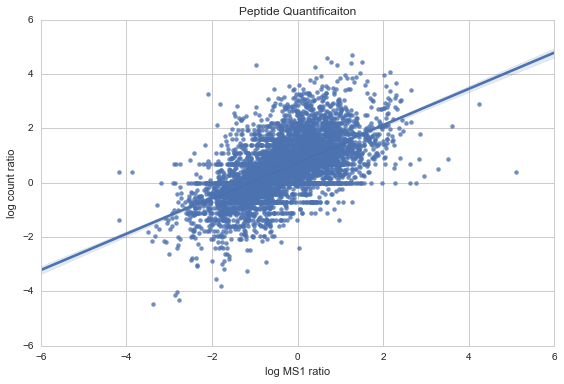

In [6]:
# Pretty Plots and Stats
import scipy
sns.set_style('whitegrid')
# Get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

# 0 Counts means no counts in N14, 0 reg fact means no real ratio.
quant_both_unorm = peps.query('reg_fact != 0 and counts != 0')
print('Numb of peptides: {}'.format(len(quant_both_unorm)))
print('Corr Coeff: {}'.format(scipy.corrcoef(np.log(quant_both_unorm['ratio']), np.log(quant_both_unorm['counts']))[0][1]))
sns.regplot(np.log(quant_both_unorm['ratio']), np.log(quant_both_unorm['counts']))
plt.title('Peptide Quantificaiton')
plt.xlabel('log MS1 ratio')
plt.ylabel('log count ratio');

### Normalizing the counts between N14 and N15 searches

Because there are always fewer counts in an N15 run than an N14 run, we will attempt to correct for this.  For a given run pair, we take the ratio of the total number of counts in the N15 search divided by the total number of counts for the N14 search.  This all peptide counts are then multipled by this ratio to attain a normalized count for each peptide.  


In [7]:
totals = peptides.T.unstack().apply(lambda c: c.sum())

conversion_fact = dict()
for pair in pairs:
    conversion_fact[pair[1]] = totals.loc[pair[0], 'counts'] / totals.loc[pair[1], 'counts']

conversion_fact

{'CL_Mix_1120_N_1': 6.5365853658536581,
 'CL_Mix_Pool_N_1': 4.6036072965771675,
 'CL_Mix_Pool_N_2': 2.3353422298751614,
 'CL_Mix_Pool_N_3': 4.3391833810888256,
 'CL_Mix_Pool_N_4': 5.9293971924029725,
 'CL_Mix_Pool_N_5': 8.4751415984896159,
 'UL_Mix_1111_N_1': 1.7398837823560487,
 'UL_Mix_1111_N_2': 1.7187941117160719,
 'UL_Mix_1111_N_3': 1.5944156836119834,
 'UL_Mix_1121_N_1': 1.6022400634354248,
 'UL_Mix_1121_N_2': 1.6021545319465083,
 'UL_Mix_1121_N_3': 1.5870039249890973,
 'UL_Mix_1121_N_4': 1.5049196064314856,
 'UL_Mix_Pool_N_1': 2.3942407024793386}

In [8]:
# Multiply count vales by these factors
tst = peptides.T.unstack()
for samp, fact in conversion_fact.items():
    tst.loc[:, pd.IndexSlice[samp, 'counts']] = tst.loc[:, pd.IndexSlice[samp, 'counts']]*fact

peptides_corr = tst.stack().T

In [9]:
peps = []
for pair in pairs:
    tmp = peptides_corr.loc[pair, pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = peptides_corr.loc[pair, pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps.append(tmp)

peps = (pd.concat(peps)
          .replace(np.inf, np.nan)
          .replace(-1*np.inf, np.nan)
          .dropna())
peps.head(10)

,back_calc,counts,ratio,reg_fact
AAAINIIPHSTGAAK,3.620134,0.783751,2.978848,0.90712
AAAQNTIPHSTGAAK,2.642190,4.023257,2.481862,0.96918
AAGVALVGGDGR,0.260274,0.287376,0.215582,0.91011
AASALCAGVR,0.100168,0.574751,0.096366,0.98082
AASATLPPITVTPVVNK,1.914523,2.873755,1.548200,0.89925
AASLGELVATHVIPR,0.344786,0.000000,0.344786,0.83950
AAWEEAEHAAK,0.777778,0.287376,0.777778,0.00000
AAYEEAEHAAK,0.802106,1.149502,0.692816,0.92938
ACDSGGILDNKPK,0.828525,0.574751,0.786931,0.97458
ACSEELGEYHVYK,4.397274,2.586380,3.824830,0.93264


### Count normalized Plot

Numb of peptides: 5146
Corr Coeff: 0.672985158729046


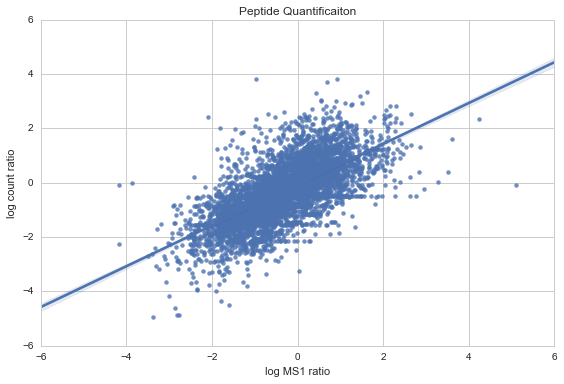

In [10]:
quant_both = peps.query('reg_fact != 0 and counts != 0')
print('Numb of peptides: {}'.format(len(quant_both)))
print('Corr Coeff: {}'.format(scipy.corrcoef(np.log(quant_both['ratio']), np.log(quant_both['counts']))[0][1]))
sns.regplot(np.log(quant_both['ratio']), np.log(quant_both['counts']))
plt.title('Peptide Quantificaiton')
plt.xlabel('log MS1 ratio')
plt.ylabel('log count ratio');

This normaliziaon helped to tighten up the graph quite a bit, increasing the correlation coefficient from .60 to .67

### See how these ratios compare at the Protein level

In [11]:
proteins = defaultdict(dict)
for locus in grouped_loci:
    for samp, qvals in locus.quantification.items():
        proteins[locus.cluster_id].update({samp: qvals})
proteins = pd.DataFrame(format_qdict(proteins))

In [12]:
totals1 = proteins.T.unstack().apply(lambda c: c.sum())

In [13]:
totals1
conversion_fact1 = dict()
for pair in pairs:
    conversion_fact1[pair[1]] = totals1.loc[pair[0], 'counts'] / totals1.loc[pair[1], 'counts']

In [14]:
conversion_fact1

{'CL_Mix_1120_N_1': 6.933786848072562,
 'CL_Mix_Pool_N_1': 5.6550398633257402,
 'CL_Mix_Pool_N_2': 2.5337931034482759,
 'CL_Mix_Pool_N_3': 4.4086799276672695,
 'CL_Mix_Pool_N_4': 7.1281640499839796,
 'CL_Mix_Pool_N_5': 9.1484615384615378,
 'UL_Mix_1111_N_1': 1.6364558429326959,
 'UL_Mix_1111_N_2': 1.413460325469913,
 'UL_Mix_1111_N_3': 1.4904046242774567,
 'UL_Mix_1121_N_1': 1.3814840093603744,
 'UL_Mix_1121_N_2': 1.4336457819437594,
 'UL_Mix_1121_N_3': 1.5761593204775024,
 'UL_Mix_1121_N_4': 1.2779974579861602,
 'UL_Mix_Pool_N_1': 3.1083267871170461}

In [15]:
tst = proteins.T.unstack()
for samp, fact in conversion_fact1.items():
    tst.loc[:, pd.IndexSlice[samp, 'counts']] = tst.loc[:, pd.IndexSlice[samp, 'counts']]*fact
proteins = tst.stack().T

In [16]:
prots = []
for pair in pairs:
    tmp = proteins.loc[pair, pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = proteins.loc[pair, pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    prots.append(tmp)

In [17]:
prots = pd.concat(prots).replace(np.inf, np.nan).replace(-1*np.inf, np.nan).dropna()

In [18]:
len(prots)

7250

In [19]:
prots.head(10)

,back_calc,counts,ratio
2011633,0.170914,0.362120,0.087153
3512858,1.286349,1.120307,1.150262
3640142,0.724960,0.763846,0.692821
3695825,0.350171,0.000000,0.362683
3762103,0.390064,0.366646,0.319297
4097327,0.398835,0.000000,0.417601
4784851,0.590375,0.448123,0.529003
5367232,1.010078,1.265802,0.938773
5564936,0.352292,0.242125,0.317968
5710574,0.273676,0.000000,0.276085


Numb of peptides: 5863
Corr Coeff: 0.6056554562034039


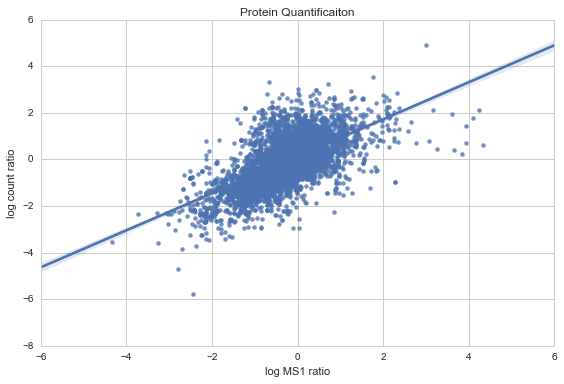

In [20]:
quant_both = prots.query('counts != 0')
print('Numb of peptides: {}'.format(len(quant_both)))
print('Corr Coeff: {}'.format(scipy.corrcoef(np.log(quant_both['ratio']), np.log(quant_both['counts']))[0][1]))
sns.regplot(np.log(quant_both['ratio']), np.log(quant_both['counts']))
plt.title('Protein Quantificaiton')
plt.xlabel('log MS1 ratio')
plt.ylabel('log count ratio');

## Variance Comparison - Counts vs Ratios

This time we will split the Unenriched samples from the BioGlyCMK Enriched Samples

In [21]:
n14_samps = [x[0] for x in pairs]
n15_samps = [x[1] for x in pairs]

unenr_n14 = [x for x in n14_samps if x.startswith('UL_')]
unenr_n15 = [x for x in n15_samps if x.startswith('UL_')]

enr_n14 = [x for x in n14_samps if x.startswith('CL_')]
enr_n15 = [x for x in n15_samps if x.startswith('CL_')]

We will use the pre-normalized counts already contained in the dataframe Peptides

In [22]:
peps = []
for n14, n15 in zip(unenr_n14, unenr_n15):
    tmp = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps.append(tmp)

In [23]:
ratio_data = pd.concat(peps, axis = 1, keys=unenr_n14).dropna(how='all')

ratio_var = ratio_data.loc[:, pd.IndexSlice[:, 'ratio']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)
count_var = ratio_data.loc[:, pd.IndexSlice[:, 'counts']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)

In [24]:
var = count_var.to_frame()
var['ratio_var'] = ratio_var
var = var.rename(columns={0: 'count_var'})

In [25]:
len(var)

5721

In [26]:
len(var.replace(0, np.nan).dropna())

928

In [27]:
var_filt = var.replace(0, np.nan).dropna()

In [28]:
var_filt['c_over_r'] = var_filt['count_var'] / var_filt['ratio_var']

In [29]:
def norm_func(x):
    """
    A normalization function for colormappinging
    Color maps go from 0 to 1 with mid value at .5
    Since we're looking at ratios, our middle value is 1
    with min 0 and max +inf.
    
    Therefore we need a funtion that turns 1 to .5, numbers < 1 to
    less than .5, approaching 0 at 0, and numbers > 1 greater than .5, 
    to approach 1 at inf.
    
    This function takes argument of log(ratio) so that colorbar on plot has log values
    """
    return np.exp(np.log(.5)/np.exp(x))

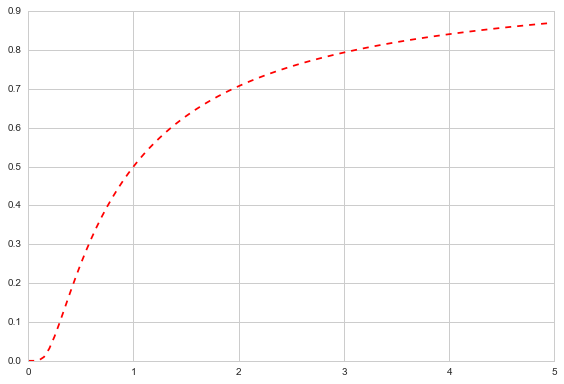

In [30]:
t = np.arange(0, 5, .05)
plt.plot(t, norm_func(np.log(t)), 'r--');

In [31]:
import matplotlib.colors as colors

class SigmoidNorm(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        return np.ma.masked_array(norm_func(value))

norm = SigmoidNorm(vmin = -2, vmax = 2)

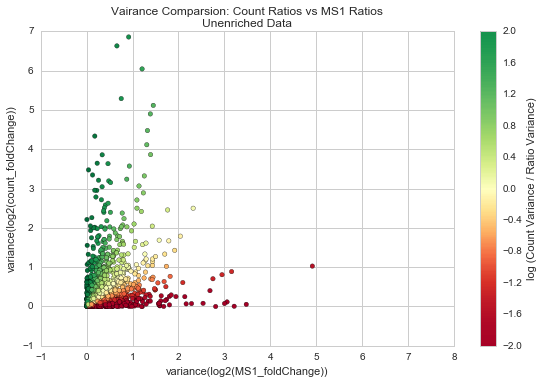

In [32]:
sns.set_style('whitegrid')
plt.scatter(var_filt['ratio_var'], var_filt['count_var'], c = np.log(var_filt['c_over_r']), cmap='RdYlGn', norm=norm)
plt.xlabel('variance(log2(MS1_foldChange))')
plt.ylabel('variance(log2(count_foldChange))')
plt.ylim([-1,7])
plt.xlim([-1,8])
cbar = plt.colorbar()
cbar.set_label('log (Count Variance / Ratio Variance)')
plt.title('Vairance Comparsion: Count Ratios vs MS1 Ratios\nUnenriched Data');

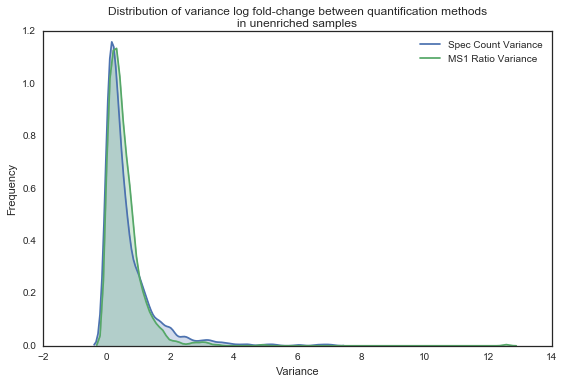

In [33]:
sns.set_style('white')
sns.kdeplot(var_filt['count_var'], shade = True, label = 'Spec Count Variance')
sns.kdeplot(var_filt['ratio_var'], shade = True, label = 'MS1 Ratio Variance')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title("Distribution of variance log fold-change between quantification methods\nin unenriched samples");

### BioGlyCMK enriched Variance

Now we will compare the variance in the ratios between technical replicaties of the BioGlyCMK enriched samples

In [34]:
peps1 = []
for n14, n15 in zip(enr_n14, enr_n15):
    tmp = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['counts', 'back_calc']]].apply(lambda c: c.iloc[0]/c.iloc[1])
    tmp = tmp.to_frame().unstack()
    tmp.columns = tmp.columns.droplevel()
    
    tmp1 = peptides_corr.loc[[n14, n15], pd.IndexSlice[:, ['ratio', 'reg_fact']]].apply(lambda c: c.iloc[0])
    tmp1 = tmp1.to_frame().unstack()
    tmp1.columns = tmp1.columns.droplevel()
    
    tmp[tmp1.columns] = tmp1[tmp1.columns]

    peps1.append(tmp)

In [35]:
ratio_data1 = pd.concat(peps1, axis = 1, keys=unenr_n14)
ratio_data1 = ratio_data1.dropna(how='all')

In [36]:
ratio_var1 = ratio_data1.loc[:, pd.IndexSlice[:, 'ratio']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)
count_var1 = ratio_data1.loc[:, pd.IndexSlice[:, 'counts']].apply(lambda r: np.nanvar(np.log2(r).replace(np.inf, np.nan).replace(-1*np.inf, np.nan)), axis = 1)

In [37]:
var1 = count_var1.to_frame()
var1['ratio_var'] = ratio_var1
var1 = var1.rename(columns={0: 'count_var'})

In [38]:
var_filt1 = var1.replace(0, np.nan).dropna()

In [39]:
var_filt1['c_over_r'] = var_filt1['count_var'] / var_filt1['ratio_var']

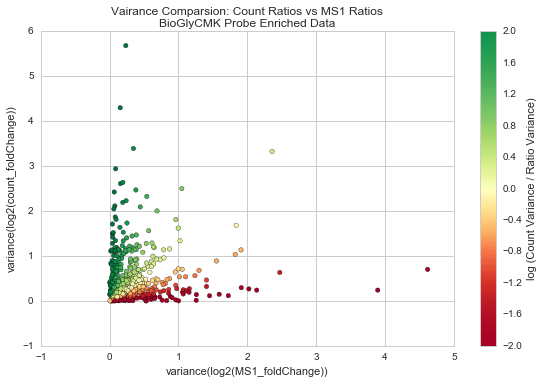

In [40]:
sns.set_style('whitegrid')
plt.scatter(var_filt1['ratio_var'], var_filt1['count_var'], c = np.log(var_filt1['c_over_r']), cmap='RdYlGn', norm=norm)
plt.xlabel('variance(log2(MS1_foldChange))')
plt.ylabel('variance(log2(count_foldChange))')
plt.ylim([-1,6])
plt.xlim([-1,5])
cbar = plt.colorbar()
cbar.set_label('log (Count Variance / Ratio Variance)')
plt.title('Vairance Comparsion: Count Ratios vs MS1 Ratios\nBioGlyCMK Probe Enriched Data');

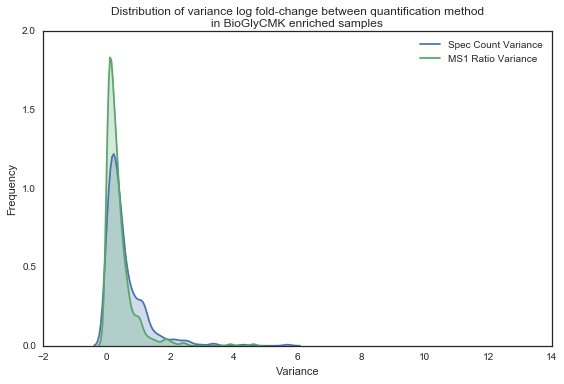

In [41]:
sns.set_style('white')
sns.kdeplot(var_filt1['count_var'], shade = True, label = 'Spec Count Variance')
sns.kdeplot(var_filt1['ratio_var'], shade = True, label = 'MS1 Ratio Variance')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.xlim([-2, 14])
plt.title("Distribution of variance log fold-change between quantification method\nin BioGlyCMK enriched samples");

## Let's see how the variance changed between Unenriched and Eneriched protocols

While it's clear there as a definite change in variance when depending on how the ratios are obtained, in the Enriched samples, its unclear what effect the enrichement step had on each of the ratio generation methods individually.  

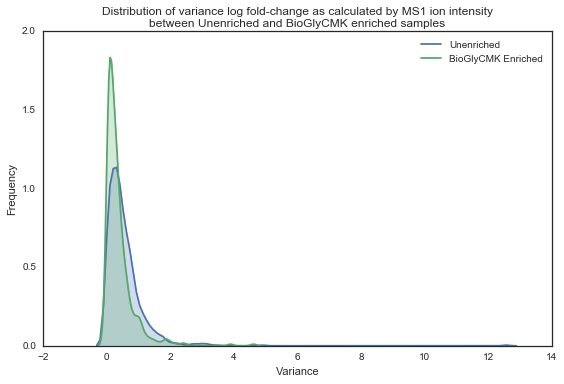

In [42]:
sns.kdeplot(var_filt['ratio_var'], shade = True, label = 'Unenriched')
sns.kdeplot(var_filt1['ratio_var'], shade = True, label = 'BioGlyCMK Enriched');
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.xlim([-2, 14])
plt.title("Distribution of variance log fold-change as calculated by MS1 ion intensity\nbetween Unenriched and BioGlyCMK enriched samples");

In the MS1 spectra ratios, the variances actually tighetend up between Unenriched and enriched samples

This is expected: Reducing the complexity of the samples may produce better readings between runs as there are fewer peptides to compete for limited detector time

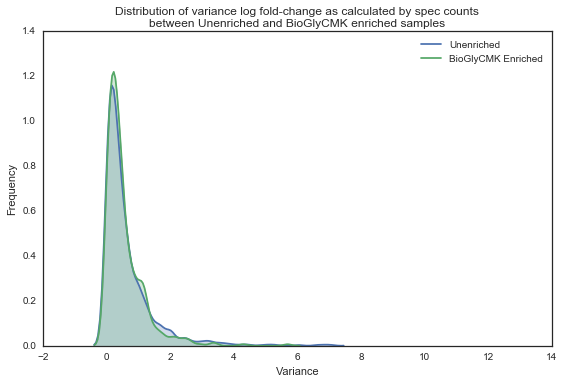

In [43]:
sns.kdeplot(var_filt['count_var'], shade = True, label = 'Unenriched')
sns.kdeplot(var_filt1['count_var'], shade = True, label = 'BioGlyCMK Enriched');
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.xlim([-2, 14])
plt.title("Distribution of variance log fold-change as calculated by spec counts\nbetween Unenriched and BioGlyCMK enriched samples");

On the other hand, the count ratio variance barley changed as the complexity reduced.  This looks like a win for the MS1 based method